In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d

2023-10-17 21:19:50.641931: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 21:19:50.642018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 21:19:50.647215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 21:19:51.385168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
directory = "abc-dataset-ply/"
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

def convert_to_binvox(path):
    point_cloud = np.loadtxt(path, skiprows=12)[:, 0:3]
    df = pd.DataFrame(data=point_cloud, columns=['x','y','z'])
    cloud = PyntCloud(df)
    voxelgrid_id = cloud.add_structure("voxelgrid", n_x=64, n_y=64, n_z=64)
    voxelgrid = cloud.structures[voxelgrid_id]
    Binary_voxel_array = voxelgrid.get_feature_vector(mode="binary")
    dataset.append(Binary_voxel_array)

for i in files:
    path = os.path.join(directory, i)
    convert_to_binvox(path)

In [3]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:100]  # Adjust the number as needed
test_dataset = dataset[100:]   # The remaining data for testing

# Define the input shape
input_shape = (64, 64, 64, 1)

In [4]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

2023-10-17 21:20:20.240011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 21:20:21.026861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 21:20:21.027322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

In [11]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=20, batch_size=10, validation_data=(test_dataset, test_dataset))
reconstructed_data = autoencoder.predict(test_dataset)

Epoch 1/20
10/10 [==============================] - 4s 304ms/step - loss: 0.2800 - val_loss: 0.2687
Epoch 2/20
10/10 [==============================] - 3s 287ms/step - loss: 0.2696 - val_loss: 0.1327
Epoch 3/20
10/10 [==============================] - 3s 288ms/step - loss: 0.0845 - val_loss: 0.0689
Epoch 4/20
10/10 [==============================] - 3s 289ms/step - loss: 0.0616 - val_loss: 0.0534
Epoch 5/20
10/10 [==============================] - 3s 290ms/step - loss: 0.0541 - val_loss: 0.0500
Epoch 6/20
10/10 [==============================] - 3s 289ms/step - loss: 0.0504 - val_loss: 0.0456
Epoch 7/20
10/10 [==============================] - 3s 289ms/step - loss: 0.0480 - val_loss: 0.0448
Epoch 8/20
10/10 [==============================] - 3s 289ms/step - loss: 0.0462 - val_loss: 0.0427
Epoch 9/20
10/10 [==============================] - 3s 289ms/step - loss: 0.0445 - val_loss: 0.0413
Epoch 10/20
10/10 [==============================] - 3s 290ms/step - loss: 0.0433 - val_loss: 0.0401

In [12]:
import matplotlib.pyplot as plt

index = 4

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35  # Adjust the threshold as needed
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

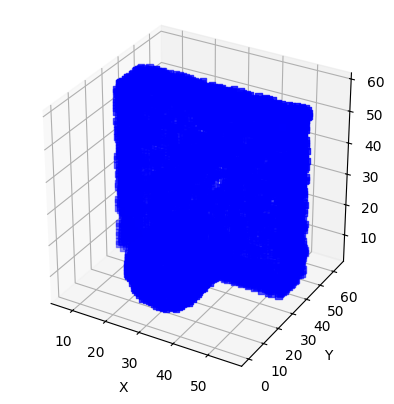

In [14]:
voxel_data = original_sample

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid for 3D plotting
x, y, z = np.indices(voxel_data.shape)

# Extract the coordinates where voxel_data is equal to 1
x1, y1, z1 = x[voxel_data == 1], y[voxel_data == 1], z[voxel_data == 1]

# Plot the voxels as points or cubes
ax.scatter(x1, y1, z1, c='b', marker='s')  # Use 'marker='s'' for cubes

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the aspect ratio to be equal to avoid distorted visualization
ax.set_box_aspect([1, 1, 1])

# Show the plot
plt.show()

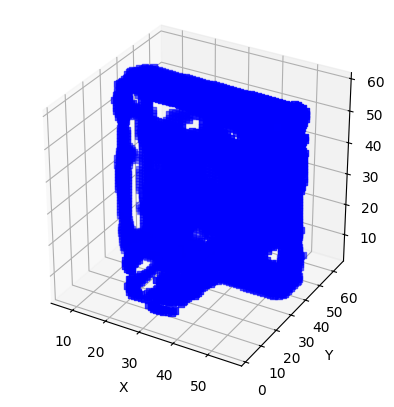

In [15]:
voxel_data = reconstructed_sample

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid for 3D plotting
x, y, z = np.indices(voxel_data.shape)

# Extract the coordinates where voxel_data is equal to 1
x1, y1, z1 = x[voxel_data == 1], y[voxel_data == 1], z[voxel_data == 1]

# Plot the voxels as points or cubes
ax.scatter(x1, y1, z1, c='b', marker='s')  # Use 'marker='s'' for cubes

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the aspect ratio to be equal to avoid distorted visualization
ax.set_box_aspect([1, 1, 1])

# Show the plot
plt.show()

In [ ]:
voxel_data = original_sample

# Create a point cloud from the voxel data
x, y, z = np.where(voxel_data == 1)
points = np.column_stack((x, y, z))
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Create a 3D visualization window
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()

# Add the point cloud to the visualization
visualizer.add_geometry(point_cloud)

# Set up the view and rendering options
view_control = visualizer.get_view_control()
view_control.set_front([0, 0, -1])
view_control.set_up([0, 1, 0])

# Run the visualization
visualizer.run()

# Close the visualization window when done
visualizer.destroy_window()

In [ ]:
voxel_data = reconstructed_sample

# Create a point cloud from the voxel data
x, y, z = np.where(voxel_data == 1)
points = np.column_stack((x, y, z))
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Create a 3D visualization window
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()

# Add the point cloud to the visualization
visualizer.add_geometry(point_cloud)

# Set up the view and rendering options
view_control = visualizer.get_view_control()
view_control.set_front([0, 0, -1])
view_control.set_up([0, 1, 0])

# Run the visualization
visualizer.run()

# Close the visualization window when done
visualizer.destroy_window()